In [ ]:
import anndata
import h5py
import json
import numpy as np
import pandas as pd
import pathlib
import scanpy as sc

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

#### Load the data 

In [ ]:
def load_adata(Qced_adata_path):
    
    adata = anndata.read_h5ad(Qced_adata_path)

    # filter the initial QCed cells
    QC_flag = [adata.obs[x] for x in adata.obs.columns if 'flag' in x]
    if len(QC_flag) > 0:
        QC_flag = np.column_stack(QC_flag).all(axis=-1)
        adata = adata[QC_flag]

    if 'Ensemble_ID' in adata.var:
        # reset the var name to Ensemble ID 
        adata.var.set_index('Ensemble_ID', inplace=True)
    if 'real_gene_name' in adata.var:
        adata.var = adata.var.rename(columns={'real_gene_name':'Gene'})

    return adata


In [ ]:
# Qced file path 
chip5_file_path = r'./../../HumanBG_stereo_seq_data/chip5_Y00550_N4P6/outs/feature_expression/Y00550N4P6.adjusted.cellbin_QC_flaged_05162025.h5ad'


In [ ]:
%%time
chip5_adata = load_adata(chip5_file_path)


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/site-packages/pandas/core/frame.py:6191: ImplicitModificationWarning: Trying to modify index of attribute `.var` of view, initializing view as actual.
  frame.index = index


CPU times: user 4 s, sys: 1.09 s, total: 5.09 s
Wall time: 5.46 s


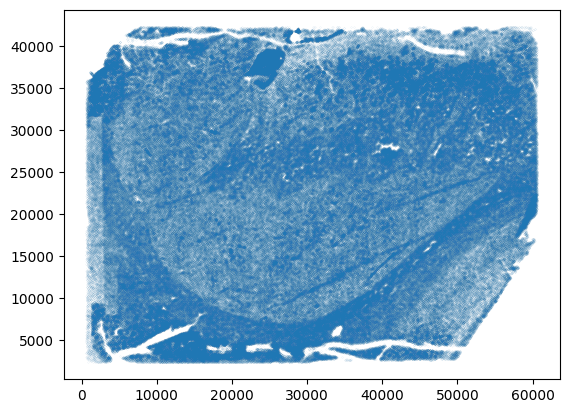

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(chip5_adata.obsm['spatial'][:,0],chip5_adata.obsm['spatial'][:,1], s = 0.001)
plt.show()



In [ ]:
# # make the cell ID unique 
chip5_adata.obs_names =  chip5_adata.obs_names.map(lambda x: 'chip5_' + str(x))


### Level 1: Graymatter(striatium),whitematter and ependymal zone

In [ ]:
adata = chip5_adata.copy()
adata

AnnData object with n_obs × n_vars = 913599 × 69294
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag'
    var: 'Gene', 'Accession', 'gene_biotype'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn'
    obsm: 'cell_border', 'spatial'

In [ ]:
adata = adata.copy()

In [ ]:
# keep record of the raw count 
adata.layers['raw_count'] = adata.X.copy()

#### Count Normalization

In [ ]:
total_count = np.array(adata.X.sum(axis=-1))
sc.pp.normalize_total(adata, target_sum=np.median(total_count))
sc.pp.log1p(adata)

In [ ]:
adata

AnnData object with n_obs × n_vars = 913599 × 69294
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag'
    var: 'Gene', 'Accession', 'gene_biotype'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn', 'log1p'
    obsm: 'cell_border', 'spatial'
    layers: 'raw_count'

#### Compute the gaussian weighted average of the expression matrix

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm

genes = list(adata.var.index)
X = adata.obsm['spatial']
d=200
D = radius_neighbors_graph(
        X, radius=d,          # keep neighbours within d
        mode='distance',      # store the actual distances (use 'connectivity' for 1s)
        include_self=True,   # no self–loops
        metric='euclidean',   # or 'cosine', etc.
        n_jobs=-1             # parallel over all CPU cores
    ).tocsr() 
W = D.copy()
w=200
W.data = np.exp(-0.5*(W.data/w)**2)

row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
#row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
D_inv = sp.diags(1.0 / row_sum)
W_norm = D_inv @ W
expr_mat = adata.X  # (n_cells × n_genes)
expr_neigh = W_norm[::11].dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                            # downsample by 11. This is for testing, later maybe better to use full data
adataN = sc.AnnData(expr_neigh, var=adata.var)
adataN.obsm['X_spatial']=adata.obsm['spatial'][::11]
adataN.obs_names = adata.obs_names[::11] # add the cell ID names
# keep record of the raw count 
adataN.layers['raw_count'] = adata.layers['raw_count'][::11]




#### Compute highly variable gene

In [ ]:
%%time
# HVG
sc.pp.highly_variable_genes(
    adataN,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=5000,    # common default
    subset=True,         # keep only HVGs moving forward
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


CPU times: user 14.3 s, sys: 1.5 s, total: 15.8 s
Wall time: 3.81 s


In [ ]:
adataN

AnnData object with n_obs × n_vars = 83055 × 5000
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'
    obsm: 'X_spatial'
    layers: 'raw_count'

### Perform the clustering

In [ ]:
%%time
sc.pp.scale(adataN, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adataN, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 20min 26s, sys: 3.75 s, total: 20min 30s
Wall time: 19.9 s


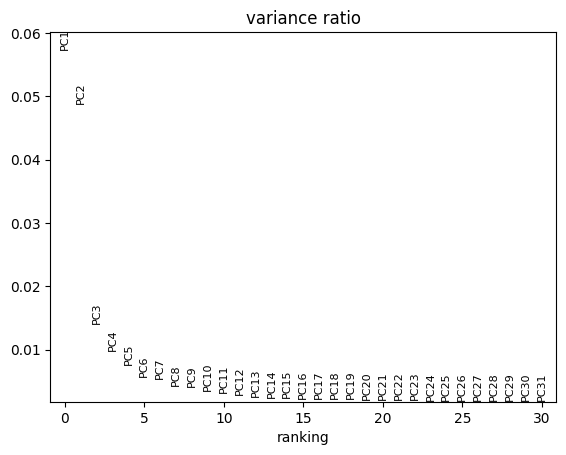

In [ ]:
sc.pl.pca_variance_ratio(adataN)

In [ ]:
%time
sc.pp.neighbors(adataN, n_neighbors=15, n_pcs = 15, use_rep = 'X_pca')  # uses PCA space by default
sc.tl.umap(adataN, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adataN, resolution=0.03)  

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 11.7 μs


/tmp/ipykernel_1374397/589796071.py:4: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adataN, resolution=0.03)


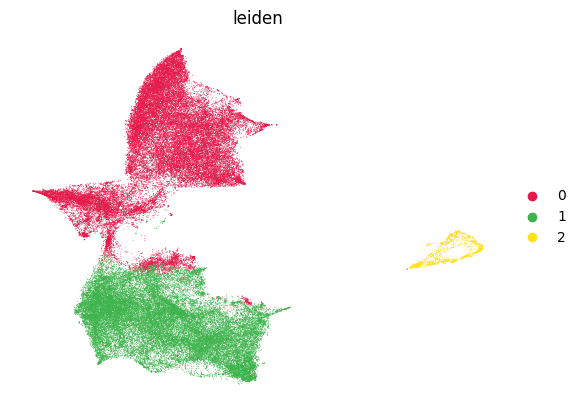

In [ ]:
# 7 . Plot UMAP coloured by Leiden clusters
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]
sc.pl.umap(adataN,
           color="leiden",        # what to colour by
           frameon=False,         # remove axes frame
        #    legend_loc="on data",
           palette=cmap)  # put cluster labels on the points


In [ ]:
leiden = adataN.obs['leiden']
np.unique(leiden)

array(['0', '1', '2'], dtype=object)

In [ ]:
color_map = {ld:clr for ld,clr in zip(adataN.obs['leiden'].cat.categories, adataN.uns['leiden_colors'])}
color_map

{'0': '#e6194b', '1': '#3cb44b', '2': '#ffe119'}

In [ ]:
adataN

AnnData object with n_obs × n_vars = 83055 × 5000
    obs: 'leiden'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [ ]:
np.sort(np.unique(adataN.obs['leiden']).astype(int))

array([0, 1, 2])

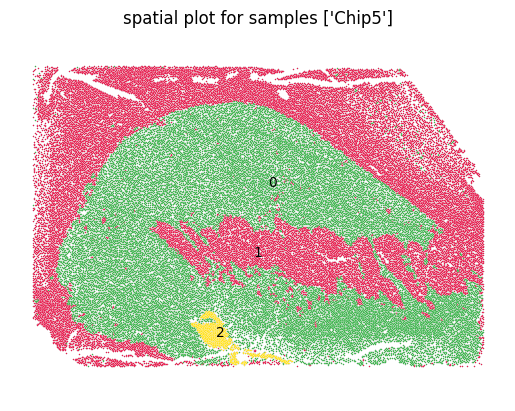

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns

XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['leiden']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for samples {["Chip5"]}', fontdict={'color':'k'})
plt.axis('equal')
plt.axis('off')
plt.show()

#### Annotation

In [ ]:
# annotation 
ledien_annotation = {0:'White_matter',
                     1:'Gray_matter',
                     2:'ependymal_zone'
                }
ledien_annotation = {str(k):v for k,v in ledien_annotation.items()}


In [ ]:
adataN.obs['Highlevel_spatialmodule'] = adataN.obs['leiden'].replace(ledien_annotation) 
adataN.obs['Highlevel_spatialmodule'] 

/tmp/ipykernel_1374397/2841511842.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adataN.obs['Highlevel_spatialmodule'] = adataN.obs['leiden'].replace(ledien_annotation)


chip5_3749506451787       Gray_matter
chip5_9874129815940      White_matter
chip5_10750303144333     White_matter
chip5_11072425691453     White_matter
chip5_13958643714470     White_matter
                             ...     
chip5_194849781359889    White_matter
chip5_220374772000012    White_matter
chip5_225494373016876    White_matter
chip5_246883310150929    White_matter
chip5_251027953591578    White_matter
Name: Highlevel_spatialmodule, Length: 83055, dtype: category
Categories (3, object): ['White_matter', 'Gray_matter', 'ependymal_zone']

In [ ]:
# remove the artifact clusteres 
keep =  adataN.obs['Highlevel_spatialmodule'].isin(['artifact'])
adataN = adataN[~keep].copy()
adataN

AnnData object with n_obs × n_vars = 83055 × 5000
    obs: 'leiden', 'Highlevel_spatialmodule'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [ ]:
np.unique(adataN.obs['Highlevel_spatialmodule'])

array(['Gray_matter', 'White_matter', 'ependymal_zone'], dtype=object)

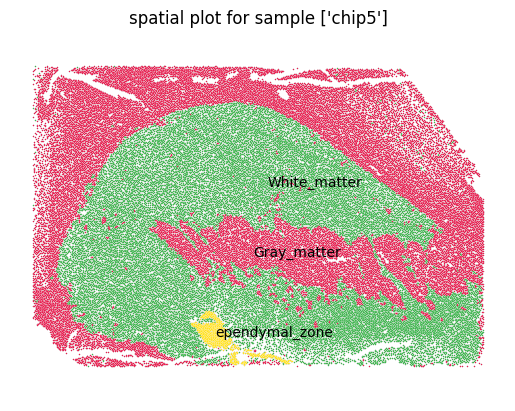

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adataN.obs['Highlevel_spatialmodule'].cat.categories)}

XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['Highlevel_spatialmodule']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)

chip = ['chip5']
plt.title(f'spatial plot for sample {chip}', fontdict={'color':'k'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [ ]:
adata

AnnData object with n_obs × n_vars = 913599 × 69294
    obs: 'dnbCount', 'area', 'orig.ident', 'x', 'y', 'TotalUMI', 'NGenes', 'mito', 'ribo', 'hemo', 'mito_flag', 'ribo_flag', 'TotalUMI_flag', 'NGenes_flag', 'molecule_gene_fold_change', 'molecule_gene_fold_change_flag', 'DNBCount_gene_foldChange', 'DNBCount_gene_foldChange_flag', 'area_flag', 'norm_TotalUMI', 'norm_TotalUMI_flag'
    var: 'Gene', 'Accession', 'gene_biotype'
    uns: 'bin_size', 'bin_type', 'key_record', 'merged', 'resolution', 'sn', 'log1p'
    obsm: 'cell_border', 'spatial'
    layers: 'raw_count'

#### Transfer the label to the full dataset

In [ ]:
# adata
import scipy
import scipy.spatial
from tqdm import tqdm 
adata.obs['Highlevel_spatialmodule'] = 'unassigned'

ref_cellID = adataN.obs_names
query_cellID = adata.obs_names

ref_spatial = adataN[ref_cellID].obsm['X_spatial'].copy()
query_spatial = adata[query_cellID].obsm['spatial']
tree = scipy.spatial.KDTree(ref_spatial)
_,ind = tree.query(query_spatial,k=1)
labels = adataN.obs.loc[ref_cellID,'Highlevel_spatialmodule'].values
adata.obs.loc[query_cellID,'Highlevel_spatialmodule'] = labels[ind]

adata.obs['Highlevel_spatialmodule'] = adata.obs['Highlevel_spatialmodule'].astype('category')

- visualize the full data to make sure the label transfer is done correctly 

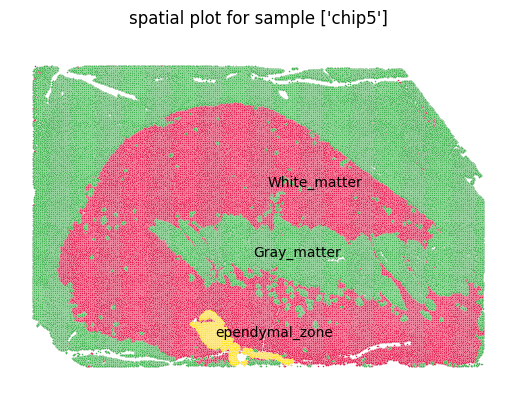

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['Highlevel_spatialmodule'].cat.categories)}

XN = np.array(adata.obsm['spatial'])
leiden = adata.obs['Highlevel_spatialmodule']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
chip_ID = ['chip5']
plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'k'})
plt.axis('equal')
plt.axis('off')
plt.show()

### Level-2: Subclustering of the Gray-matter -> Ca(Cuadate),Pu(Putamen) and NAC(nucleus accumbens)

In [ ]:
np.unique(adata.obs['Highlevel_spatialmodule'])

array(['Gray_matter', 'White_matter', 'ependymal_zone'], dtype=object)

#### Subset the data to graymatter and compute the spatially weighted expression matrix

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm
genes = list(adata.var.index)

GM_cell_idx = np.where(adata.obs['Highlevel_spatialmodule'].isin(['Gray_matter']))[0]
# for sake of computational ease downsample by 5
GM_cell_idx = np.random.choice(GM_cell_idx, size = len(GM_cell_idx)//5, replace=False)

X = adata[GM_cell_idx].obsm['spatial']
d=1700
D = radius_neighbors_graph(
        X, radius=d,          # keep neighbours within d
        mode='distance',      # store the actual distances (use 'connectivity' for 1s)
        include_self=True,   # no self–loops
        metric='euclidean',   # or 'cosine', etc.
        n_jobs=-1             # parallel over all CPU cores
    ).tocsr() 
W = D.copy()
w=500 # this will determine the decay rate of the gaussian 
W.data = np.exp(-0.5*(W.data/w)**2)

row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
#row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
D_inv = sp.diags(1.0 / row_sum)
W_norm = D_inv @ W
expr_mat = adata[GM_cell_idx].X  # (n_cells × n_genes)
expr_neigh = W_norm.dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                            # downsample by 11. This is for testing, later maybe better to use full data
adataN = sc.AnnData(expr_neigh, var=adata.var)
adataN.obsm['X_spatial']=adata[GM_cell_idx].obsm['spatial']
adataN.obs_names = adata[GM_cell_idx].obs_names # add the cell ID names
# keep record of the raw count 
adataN.layers['raw_count'] = adata[GM_cell_idx].layers['raw_count']




#### Get highly variable genes

In [ ]:
# HVG
sc.pp.highly_variable_genes(
    adataN,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=3000,    # common default
    subset=True,         # keep only HVGs moving forward
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


#### Perform clustering 

In [ ]:
adataN

AnnData object with n_obs × n_vars = 86847 × 69294
    var: 'Gene', 'Accession', 'gene_biotype'
    obsm: 'X_spatial'
    layers: 'raw_count'

In [ ]:
%%time
sc.pp.scale(adataN, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adataN, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']


/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 9min 1s, sys: 2.51 s, total: 9min 4s
Wall time: 11.9 s


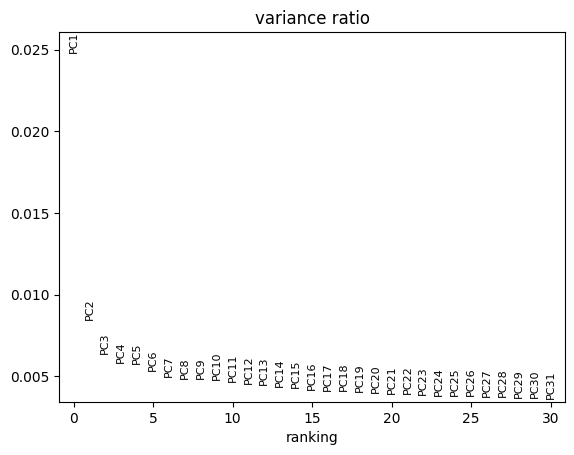

In [ ]:
sc.pl.pca_variance_ratio(adataN)

In [ ]:
%time
# clustering 
sc.pp.neighbors(adataN, n_neighbors=15, n_pcs = 15, use_rep = 'X_pca')  # uses PCA space by default
sc.tl.umap(adataN, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adataN, resolution=0.002)  

CPU times: user 4 μs, sys: 0 ns, total: 4 μs
Wall time: 8.82 μs


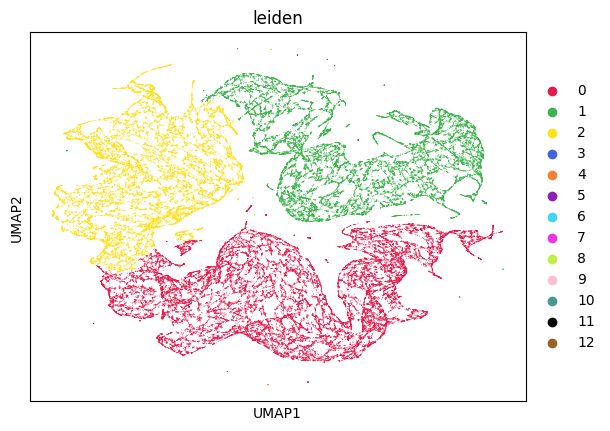

In [ ]:
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#030303", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

sc.pl.umap(
    adataN,
    color = ['leiden'],
    palette = cmap
)

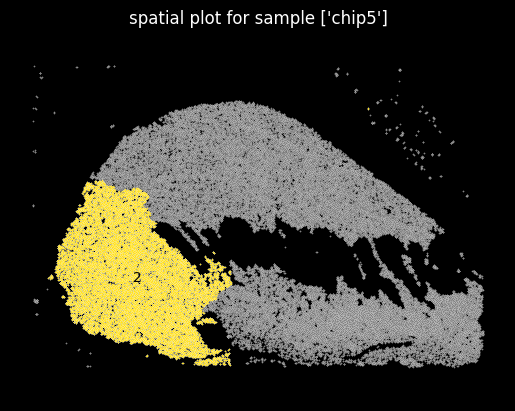

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adataN.obs['leiden'].cat.categories)}

XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['leiden']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in ['2']:#np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [ ]:
np.sort(np.unique(adataN.obs['leiden']).astype(int))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

#### Annotation

In [ ]:
region_mapper = {
                 0:'Putamen',
                 1:'Caudate',
                 2:'NAC',
                 } 

region_mapper.update({idx:'artifact' for idx in [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12]})
region_mapper = {str(k):v for k,v in region_mapper.items()}
adataN.obs['spatialmodule_GrayMatter_subclustered'] = adataN.obs['leiden'].replace(region_mapper)


/tmp/ipykernel_1374397/4001048457.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adataN.obs['spatialmodule_GrayMatter_subclustered'] = adataN.obs['leiden'].replace(region_mapper)


In [ ]:
np.unique(adataN.obs['spatialmodule_GrayMatter_subclustered'])

array(['Caudate', 'NAC', 'Putamen', 'artifact'], dtype=object)

In [ ]:
# remove the artifact clusteres 
keep = ~adataN.obs['spatialmodule_GrayMatter_subclustered'].isin(['artifact'])
adata_weightedAvg = adataN[keep].copy()
adata_weightedAvg

AnnData object with n_obs × n_vars = 86715 × 3000
    obs: 'leiden', 'spatialmodule_GrayMatter_subclustered'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

#### Transfer the label to the full data 

In [ ]:
adata.obs['spatialmodule_GrayMatter_subclustered'] =  adata.obs['Highlevel_spatialmodule'].copy()
adata.obs['spatialmodule_GrayMatter_subclustered'] = adata.obs['spatialmodule_GrayMatter_subclustered'].astype('str')
cellID = adata[adata.obs['spatialmodule_GrayMatter_subclustered'].isin(['Gray_matter'])].obs_names

tree = scipy.spatial.KDTree(adata_weightedAvg.obsm['X_spatial'])
_,ind = tree.query(adata[cellID].obsm['spatial'], k = 1)

adata.obs.loc[cellID,'spatialmodule_GrayMatter_subclustered'] = adata_weightedAvg.obs['spatialmodule_GrayMatter_subclustered'].values[ind]

adata.obs['spatialmodule_GrayMatter_subclustered'] = adata.obs['spatialmodule_GrayMatter_subclustered'].astype('category') 

- plot the data to make sure the label transfer is done correctly 

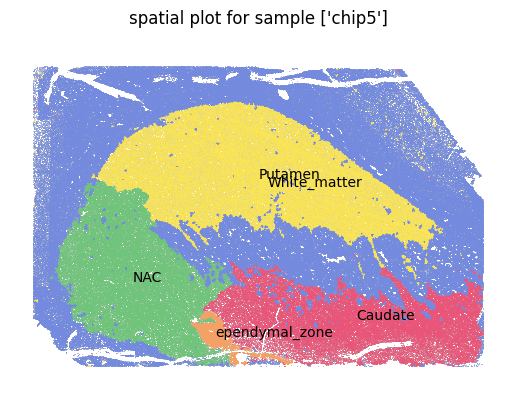

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['spatialmodule_GrayMatter_subclustered'].cat.categories)}

XN = np.array(adata.obsm['spatial'])
leiden = adata.obs['spatialmodule_GrayMatter_subclustered']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=0.2,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=0.2,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)

plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'k'})
plt.axis('equal')
plt.axis('off')
plt.show()

### Level 3: Subclustering of the NAC -> NAC shell vs NAC core

In [ ]:
np.unique(adata.obs['spatialmodule_GrayMatter_subclustered'])

array(['Caudate', 'NAC', 'Putamen', 'White_matter', 'ependymal_zone'],
      dtype=object)

#### Subset to the NAC and computed the spatially weighted average count matrix 

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm

genes = list(adata.var.index)
GM_cell_idx = np.where(adata.obs['spatialmodule_GrayMatter_subclustered'].isin(['NAC']))[0]
# for sake of computational ease downsample by 5
GM_cell_idx = np.random.choice(GM_cell_idx, size = len(GM_cell_idx)//5, replace=False)

X = adata[GM_cell_idx].obsm['spatial']
d=900
D = radius_neighbors_graph(
        X, radius=d,          # keep neighbours within d
        mode='distance',      # store the actual distances (use 'connectivity' for 1s)
        include_self=True,   # no self–loops
        metric='euclidean',   # or 'cosine', etc.
        n_jobs=-1             # parallel over all CPU cores
    ).tocsr() 
W = D.copy()
w=500 # this will determine the decay rate of the gaussian 
W.data = np.exp(-0.5*(W.data/w)**2)

row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
#row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
D_inv = sp.diags(1.0 / row_sum)
W_norm = D_inv @ W
expr_mat = adata[GM_cell_idx].X  # (n_cells × n_genes)
expr_neigh = W_norm.dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                            # downsample by 11. This is for testing, later maybe better to use full data
adataN = sc.AnnData(expr_neigh, var=adata.var)
adataN.obsm['X_spatial']=adata[GM_cell_idx].obsm['spatial']
adataN.obs_names = adata[GM_cell_idx].obs_names # add the cell ID names
# keep record of the raw count 
adataN.layers['raw_count'] = adata[GM_cell_idx].layers['raw_count']

#### Compute the highly variable genes

In [ ]:
# HVG
sc.pp.highly_variable_genes(
    adataN,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=5000,    # common default
    subset=True,         # keep only HVGs moving forward
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


#### Perform clustering 

In [ ]:
%%time
sc.pp.scale(adataN, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adataN, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']

/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 10min 11s, sys: 1.22 s, total: 10min 12s
Wall time: 8.75 s


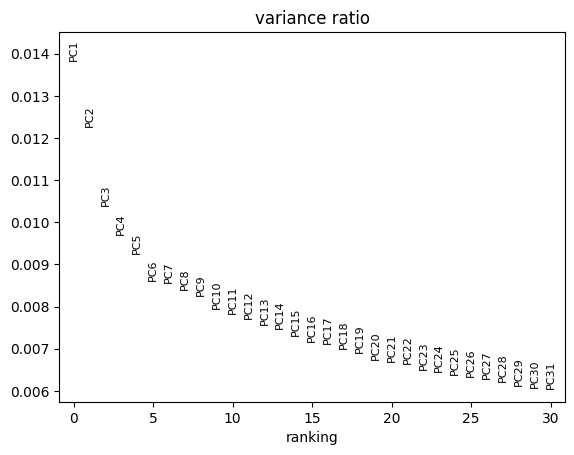

In [ ]:
sc.pl.pca_variance_ratio(adataN)

In [ ]:
%time
# clustering 
sc.pp.neighbors(adataN, n_neighbors=10, n_pcs = 45, use_rep = 'X_pca')  # uses PCA space by default
sc.tl.umap(adataN, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adataN, resolution=0.01) 

CPU times: user 5 μs, sys: 0 ns, total: 5 μs
Wall time: 9.78 μs


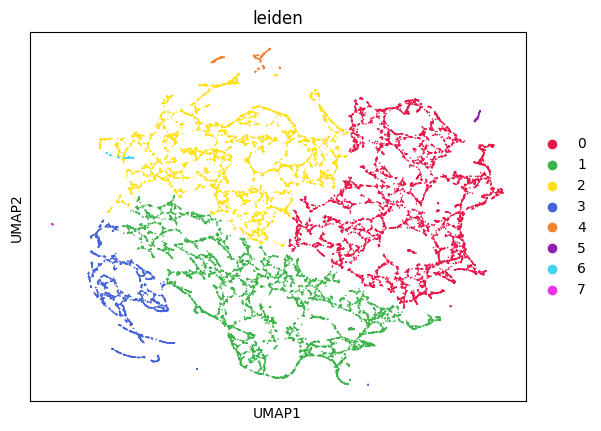

In [ ]:
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#030303", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

sc.pl.umap(
    adataN,
    color = ['leiden'],
    palette = cmap
)

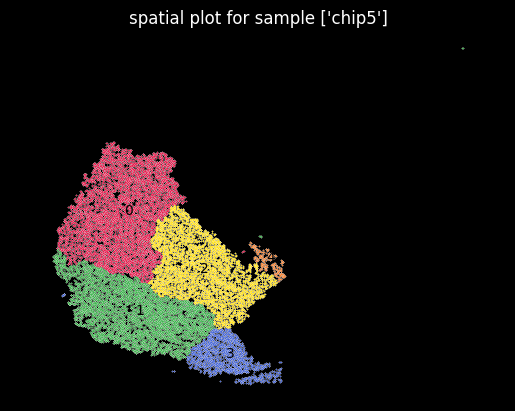

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adataN.obs['leiden'].cat.categories)}

XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['leiden']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [ ]:
np.unique(leiden)

array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype=object)

#### Annotation

In [ ]:
region_mapper = {0:'NAC_shell',
                 1:'NAC_shell',
                 2:'NAC_core',
                 3:'NAC_shell',
                 4:'VeP'
                 } 
region_mapper.update({i:'artifact' for i in [ '5', '6', '7']})
region_mapper = {str(k):v for k,v in region_mapper.items()}
adataN.obs['spatialmodule_NAC_subclustered'] = adataN.obs['leiden'].replace(region_mapper)
adataN.obs['spatialmodule_NAC_subclustered']

/tmp/ipykernel_1374397/3904013206.py:9: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adataN.obs['spatialmodule_NAC_subclustered'] = adataN.obs['leiden'].replace(region_mapper)


chip5_34024730938223     artifact
chip5_81243601397948     NAC_core
chip5_92238717689563    NAC_shell
chip5_32018981225925    NAC_shell
chip5_93415538719004     NAC_core
                          ...    
chip5_92337501927296     NAC_core
chip5_65425236846594     NAC_core
chip5_57166014733768    NAC_shell
chip5_33118492851463    NAC_shell
chip5_91482803442094    NAC_shell
Name: spatialmodule_NAC_subclustered, Length: 23444, dtype: category
Categories (4, object): ['NAC_shell', 'NAC_core', 'VeP', 'artifact']

In [ ]:
# remove artifact clusters 
keep = ~adataN.obs['spatialmodule_NAC_subclustered'].isin(['artifact'])
adataN = adataN[keep].copy()
adataN

AnnData object with n_obs × n_vars = 23240 × 5000
    obs: 'leiden', 'spatialmodule_NAC_subclustered'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

In [ ]:
np.unique(adata.obs['spatialmodule_GrayMatter_subclustered'])

array(['Caudate', 'NAC', 'Putamen', 'White_matter', 'ependymal_zone'],
      dtype=object)

#### Transfer the labels to the full dataset

In [ ]:
adata.obs['spatialmodule_NAC_subclustered'] =  adata.obs['spatialmodule_GrayMatter_subclustered'].copy()
adata.obs['spatialmodule_NAC_subclustered'] = adata.obs['spatialmodule_NAC_subclustered'].astype('str')
cellID = adata[adata.obs['spatialmodule_NAC_subclustered'].isin(['NAC'])].obs_names

tree = scipy.spatial.KDTree(adataN.obsm['X_spatial'])
_,ind = tree.query(adata[cellID].obsm['spatial'], k = 1)

adata.obs.loc[cellID,'spatialmodule_NAC_subclustered'] = adataN.obs['spatialmodule_NAC_subclustered'].values[ind]

adata.obs['spatialmodule_NAC_subclustered'] = adata.obs['spatialmodule_NAC_subclustered'].astype('category') 

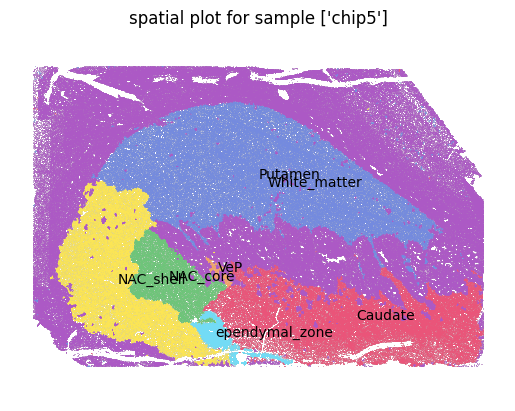

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['spatialmodule_NAC_subclustered'].cat.categories)}

XN = np.array(adata.obsm['spatial'])
leiden = adata.obs['spatialmodule_NAC_subclustered']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=0.2,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=0.2,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)

plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'k'})
plt.axis('equal')
plt.axis('off')
plt.show()

### Level 4: Subclustering of the Caudate -> Caudate and BNST

In [ ]:
np.unique(adata.obs['spatialmodule_NAC_subclustered'])

array(['Caudate', 'NAC_core', 'NAC_shell', 'Putamen', 'VeP',
       'White_matter', 'ependymal_zone'], dtype=object)

### Subset the data to caudate and compute the spatially weighted average gene expression matrix

In [ ]:
from sklearn.neighbors import radius_neighbors_graph
import numpy as np
import scipy.sparse as sp
import tqdm

genes = list(adata.var.index)
GM_cell_idx = np.where(adata.obs['spatialmodule_NAC_subclustered'].isin(['Caudate']))[0]
# for sake of computational ease downsample by 5
GM_cell_idx = np.random.choice(GM_cell_idx, size = len(GM_cell_idx)//5, replace=False)

X = adata[GM_cell_idx].obsm['spatial']
d=500
D = radius_neighbors_graph(
        X, radius=d,          # keep neighbours within d
        mode='distance',      # store the actual distances (use 'connectivity' for 1s)
        include_self=True,   # no self–loops
        metric='euclidean',   # or 'cosine', etc.
        n_jobs=-1             # parallel over all CPU cores
    ).tocsr() 
W = D.copy()
w=500 # this will determine the decay rate of the gaussian 
W.data = np.exp(-0.5*(W.data/w)**2)

row_sum = np.array(W.sum(axis=1)).ravel()                # degree / weight per cell
#row_sum[row_sum == 0] = 1                                # avoid divide‑by‑zero
D_inv = sp.diags(1.0 / row_sum)
W_norm = D_inv @ W
expr_mat = adata[GM_cell_idx].X  # (n_cells × n_genes)
expr_neigh = W_norm.dot(expr_mat)  # This is same as matrix multiplication (W_norm @ expr_mat)
                                            # downsample by 11. This is for testing, later maybe better to use full data
adataN = sc.AnnData(expr_neigh, var=adata.var)
adataN.obsm['X_spatial']=adata[GM_cell_idx].obsm['spatial']
adataN.obs_names = adata[GM_cell_idx].obs_names # add the cell ID names
# keep record of the raw count 
adataN.layers['raw_count'] = adata[GM_cell_idx].layers['raw_count']

#### Get the highly variable genes

In [ ]:
# HVG
sc.pp.highly_variable_genes(
    adataN,
    flavor="seurat_v3",  # or 'cell_ranger', 'seurat', 'pearson_residuals'
    n_top_genes=5000,    # common default
    subset=True,         # keep only HVGs moving forward
    )

/home/exx/.local/lib/python3.11/site-packages/legacy_api_wrap/__init__.py:82: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  return fn(*args_all, **kw)


#### Perform clustering 

In [ ]:
%%time
sc.pp.scale(adataN, max_value=10)    # z‑score per gene; caps extreme values
sc.tl.pca(adataN, svd_solver="arpack", n_comps = 50)   # stores PCs in adata.obsm['X_pca']

/home/exx/.conda/envs/rapid_scanpy/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


CPU times: user 12min 13s, sys: 1.66 s, total: 12min 15s
Wall time: 10.7 s


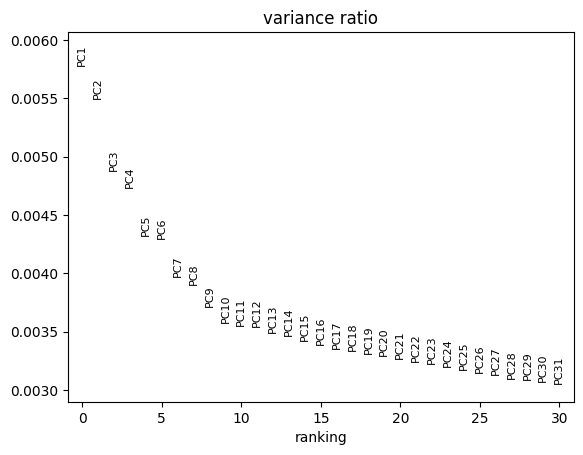

In [ ]:
sc.pl.pca_variance_ratio(adataN)

In [ ]:
%time
# clustering 
sc.pp.neighbors(adataN, n_neighbors=15, n_pcs = 15, use_rep = 'X_pca')  # uses PCA space by default
sc.tl.umap(adataN, min_dist=0.1, spread=0.7)   # tweak parameters as needed
sc.tl.leiden(adataN, resolution=0.01) 

CPU times: user 6 μs, sys: 0 ns, total: 6 μs
Wall time: 10 μs


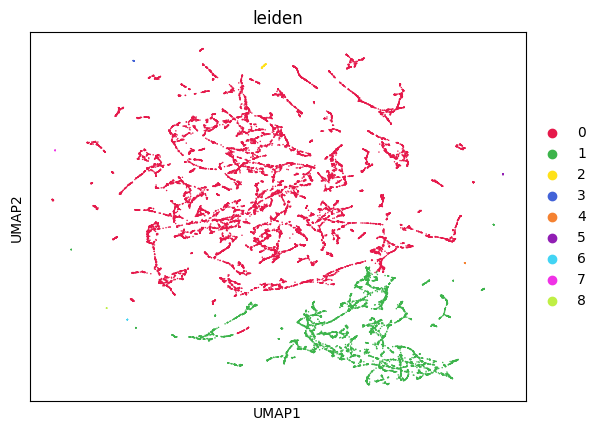

In [ ]:
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#030303", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

sc.pl.umap(
    adataN,
    color = ['leiden'],
    palette = cmap
)

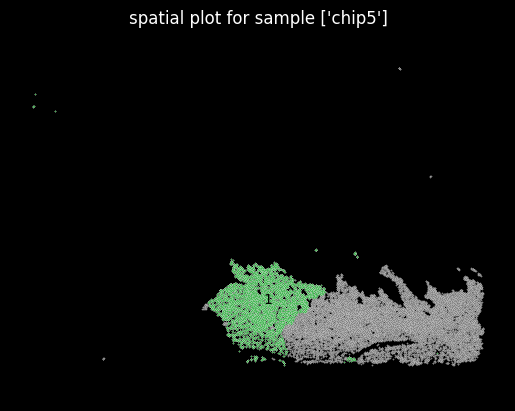

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
cmap = ["#e6194B", "#3cb44b", "#ffe119", "#4363d8", "#f58231", "#911eb4", "#42d4f4", "#f032e6", "#bfef45",
        "#fabed4", "#469990", "#dcbeff", "#9A6324", "#fffac8", "#800000", "#aaffc3", "#808000", "#ffd8b1",
        "#000075", "#a9a9a9",[0,0.2,0]]

color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adataN.obs['leiden'].cat.categories)}

XN = np.array(adataN.obsm['X_spatial'])
leiden = adataN.obs['leiden']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='k')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=1,c='gray',ax = ax)
for ld in ['1']:#np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=1,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)
    
plt.title(f'spatial plot for sample {chip}', fontdict={'color':'w'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [ ]:
np.sort(np.unique(leiden).astype(int))

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

#### Annotation

In [ ]:
region_mapper = {0:'Caudate',
                 1:'BNST'} 
region_mapper.update({idx:'artifact' for idx in [2, 3, 4, 5, 6, 7, 8]})
region_mapper = {str(k):v for k,v in region_mapper.items()}
adataN.obs['spatialmodule_Caudate_subclustered'] = adataN.obs['leiden'].replace(region_mapper)
np.unique(adataN.obs['spatialmodule_Caudate_subclustered'])

/tmp/ipykernel_1374397/2836524736.py:5: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adataN.obs['spatialmodule_Caudate_subclustered'] = adataN.obs['leiden'].replace(region_mapper)


array(['BNST', 'Caudate', 'artifact'], dtype=object)

In [ ]:
keep = ~adataN.obs['spatialmodule_Caudate_subclustered'].isin(['artifact'])
adataN = adataN[keep].copy()
adataN

AnnData object with n_obs × n_vars = 26610 × 5000
    obs: 'leiden', 'spatialmodule_Caudate_subclustered'
    var: 'Gene', 'Accession', 'gene_biotype', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count'
    obsp: 'distances', 'connectivities'

#### Transfer the label to the full data

In [ ]:
adata.obs['spatialmodule_Caudate_subclustered'] =  adata.obs['spatialmodule_NAC_subclustered'].copy()
adata.obs['spatialmodule_Caudate_subclustered'] = adata.obs['spatialmodule_Caudate_subclustered'].astype('str')
cellID = adata[adata.obs['spatialmodule_Caudate_subclustered'].isin(['Caudate'])].obs_names

tree = scipy.spatial.KDTree(adataN.obsm['X_spatial'])
_,ind = tree.query(adata[cellID].obsm['spatial'], k = 1)

adata.obs.loc[cellID,'spatialmodule_Caudate_subclustered'] = adataN.obs['spatialmodule_Caudate_subclustered'].values[ind]

adata.obs['spatialmodule_Caudate_subclustered'] = adata.obs['spatialmodule_Caudate_subclustered'].astype('category') 

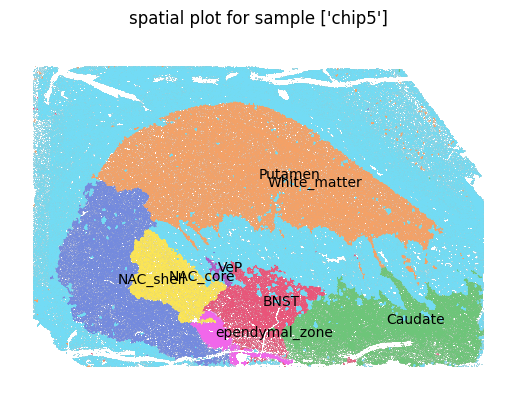

In [ ]:
import matplotlib.pylab as plt
import seaborn as sns
color_map = {clst:cmap[i%len(cmap)] for i,clst  in enumerate(adata.obs['spatialmodule_Caudate_subclustered'].cat.categories)}

XN = np.array(adata.obsm['spatial'])
leiden = adata.obs['spatialmodule_Caudate_subclustered']

fig,ax = plt.subplots(1,1,dpi=100,facecolor='w')
sns.scatterplot(x = XN[:,0],y = -XN[:,1],s=0.2,c='gray',ax = ax)
for ld in np.unique(leiden):
    sns.scatterplot(x = XN[leiden==ld,0],y = -XN[leiden==ld,1],s=0.2,c=color_map[ld], ax = ax)
    plt.text(np.median(XN[leiden==ld,0]),np.median(-XN[leiden==ld,1]),ld)

plt.title(f'spatial plot for sample {chip_ID}', fontdict={'color':'k'})
plt.axis('equal')
plt.axis('off')
plt.show()

In [ ]:
# save what you have for known.
adata.obs.to_csv(r'./../../Spatial_transcriptional_module_analysis/processed_data/chip5/Hierarchical_spatialModule_chip5.csv')